In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from n3fit.model_gen import pdfNN_layer_generator
from n3fit.io.writer import XGRID

from validphys.api import API

Using Keras backend


# Configuration variables

In [2]:
# Number of networks to initialize with random parameters
number_of_networks = 1000

# input xgrid for which to produce the corresponding outputs
# reshape is needed for model input
input_xgrid = input_xgrid = XGRID.reshape(1,-1)

# Seed for the initialisation
seed = 1408697729
np.random.seed(seed)

In [3]:
# plot settings
pdf_names = ["\Sigma", "g", "V", "V3", "V8", "T3", "T8", "T15"]
color = "C0"

<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_57797/977203723.py:2: SyntaxWarning: invalid escape sequence '\S'
  pdf_names = ["\Sigma", "g", "V", "V3", "V8", "T3", "T8", "T15"]


# Generating the ensemble of models
Here the models are evaluated on the input `input_xgrid`.

In [4]:
# read basis settings from a fit runcard (optional, but basis_info is useful)
fit_info = API.fit(fit="NNPDF40_nnlo_as_01180_1000").as_input()

basis_info = fit_info["fitting"]["basis"]

nodes = fit_info["parameters"]["nodes_per_layer"]
activations = fit_info["parameters"]["activation_per_layer"]
initializer_name = fit_info["parameters"]["initializer"]
layer_type = fit_info["parameters"]["layer_type"]
dropout = fit_info["parameters"]["dropout"]

In [5]:
# Unset pre-processing
basis_info_no_pre_proc = [basis_info[i].copy() for i in range(len(basis_info))]
for info in basis_info_no_pre_proc:
    info['smallx'] = [1,1]
    info['largex'] = [0,0]

# NNPDF prior no pre-processing no sumrules

In [6]:
# Generating the NNPDF model
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        nodes=nodes,
        activations=activations,
        initializer_name=initializer_name,
        layer_type="dense",
        flav_info=basis_info_no_pre_proc,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule=False, # NOTE: imposing sumrules will break Gaussianity to a large extent
        scaler=None,
        num_replicas = 1,
        photons=None,
        replica_axis=True,
    )

    # Generate predictions in 14-flavor basis
    out = pdf_model.predict( {"pdf_input": input_xgrid}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
  
nn_outputs = np.array(nn_outputs)

100%|██████████| 1000/1000 [01:31<00:00, 10.96it/s]


# Plotting the functional priors

<Figure size 640x480 with 0 Axes>

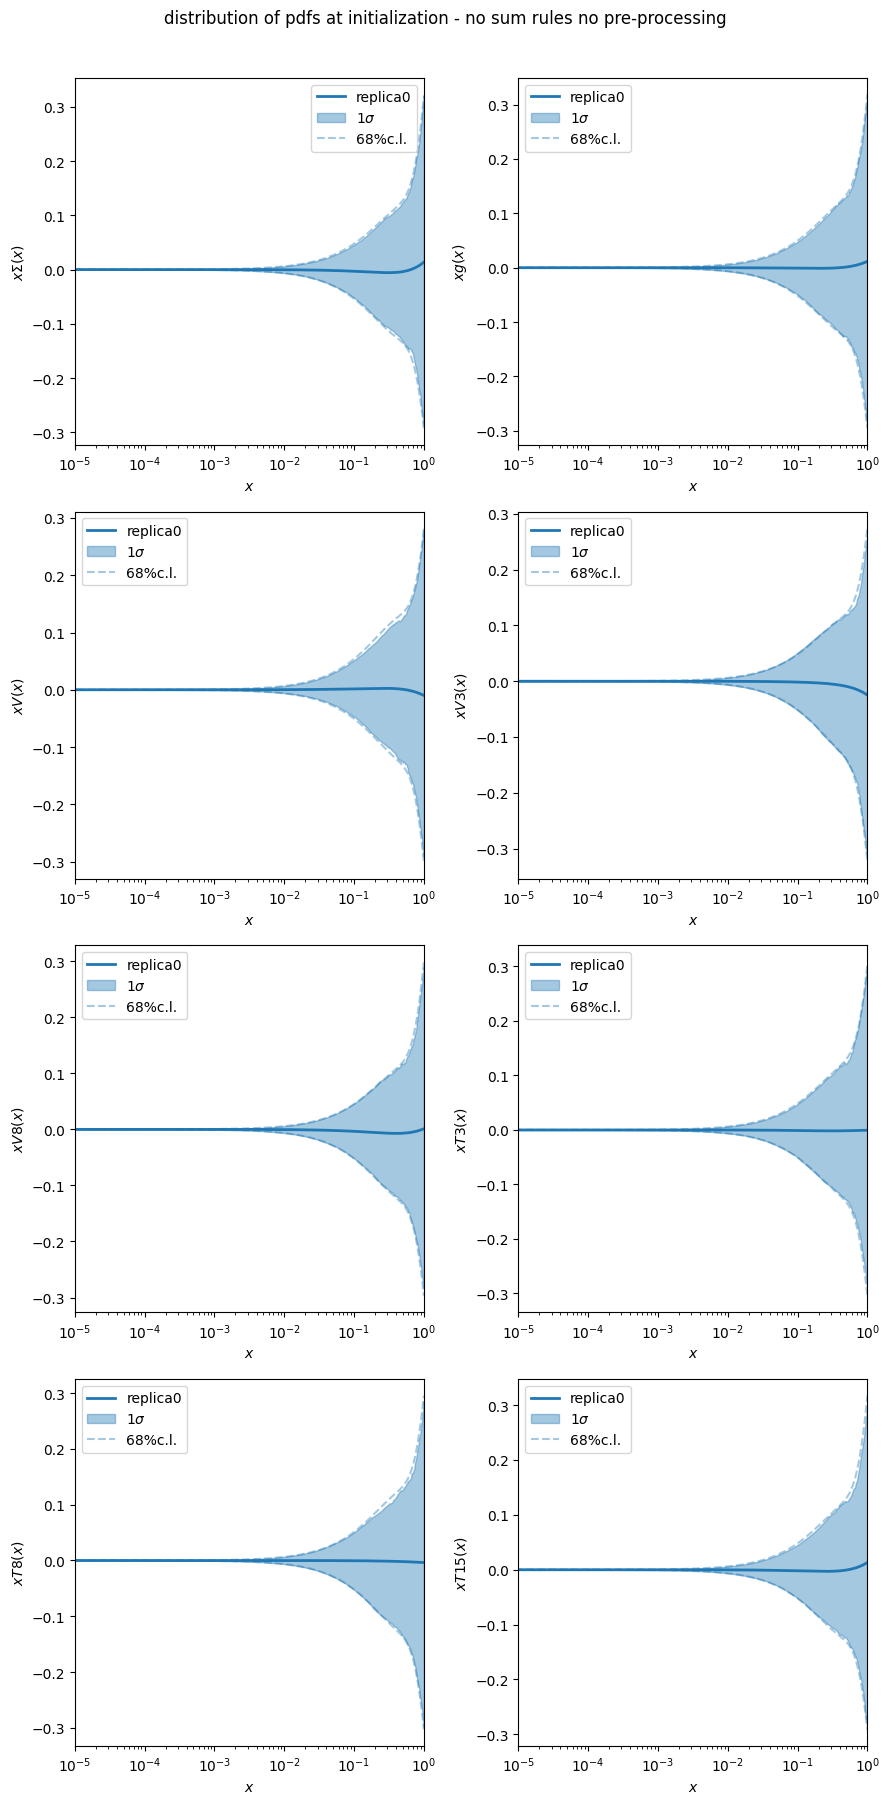

In [7]:
plt.clf()
fig_1, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(input_xgrid[0], input_xgrid[0]*cl_low, input_xgrid[0]*cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig_1.suptitle("distribution of pdfs at initialization - no sum rules no pre-processing\n", y=1)
fig_1.tight_layout()
fig_1.savefig('nnpdf_prior_no_sumrule_no_pre_proc.png')

# Imposing sum rules

In [8]:
# Generating the NNPDF model
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        nodes=nodes,
        activations=activations,
        initializer_name=initializer_name,
        layer_type="dense",
        flav_info=basis_info_no_pre_proc,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule=True, # NOTE: imposing sumrules will break Gaussianity to a large extent
        scaler=None,
        num_replicas = 1,
        photons=None,
        replica_axis=True,
    )

    # Generate predictions in 14-flavor basis
    out = pdf_model.predict( {"pdf_input": input_xgrid}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
  
nn_outputs = np.array(nn_outputs)

100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


<Figure size 640x480 with 0 Axes>

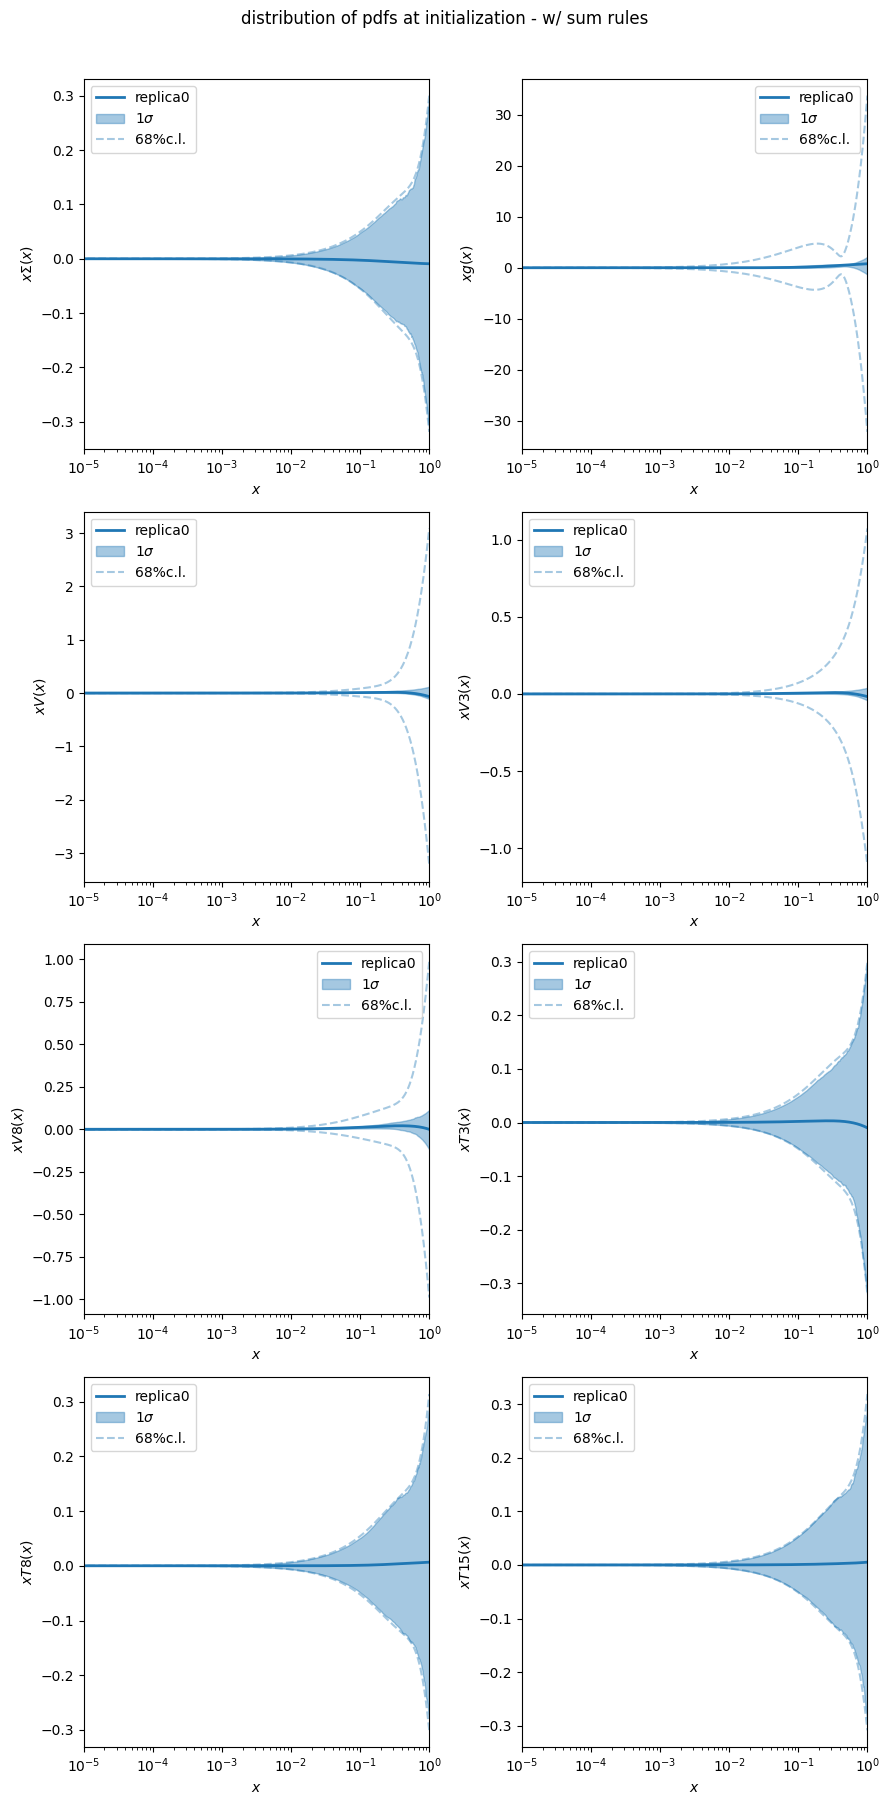

In [9]:
plt.clf()
fig_2, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(input_xgrid[0], input_xgrid[0]*cl_low, input_xgrid[0]*cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig_2.suptitle("distribution of pdfs at initialization - w/ sum rules\n", y = 1)
fig_2.tight_layout()
fig_2.savefig('nnpdf_prior_no_pre_proc.png')

# With pre processing

In [10]:
# Generating the NNPDF model
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        nodes=nodes,
        activations=activations,
        initializer_name=initializer_name,
        layer_type="dense",
        flav_info=basis_info,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule=False, # NOTE: imposing sumrules will break Gaussianity to a large extent
        scaler=None,
        num_replicas = 1,
        photons=None,
        replica_axis=True,
    )

    # Generate predictions in 14-flavor basis
    out = pdf_model.predict( {"pdf_input": input_xgrid}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
  
nn_outputs = np.array(nn_outputs)

100%|██████████| 1000/1000 [01:32<00:00, 10.76it/s]


<Figure size 640x480 with 0 Axes>

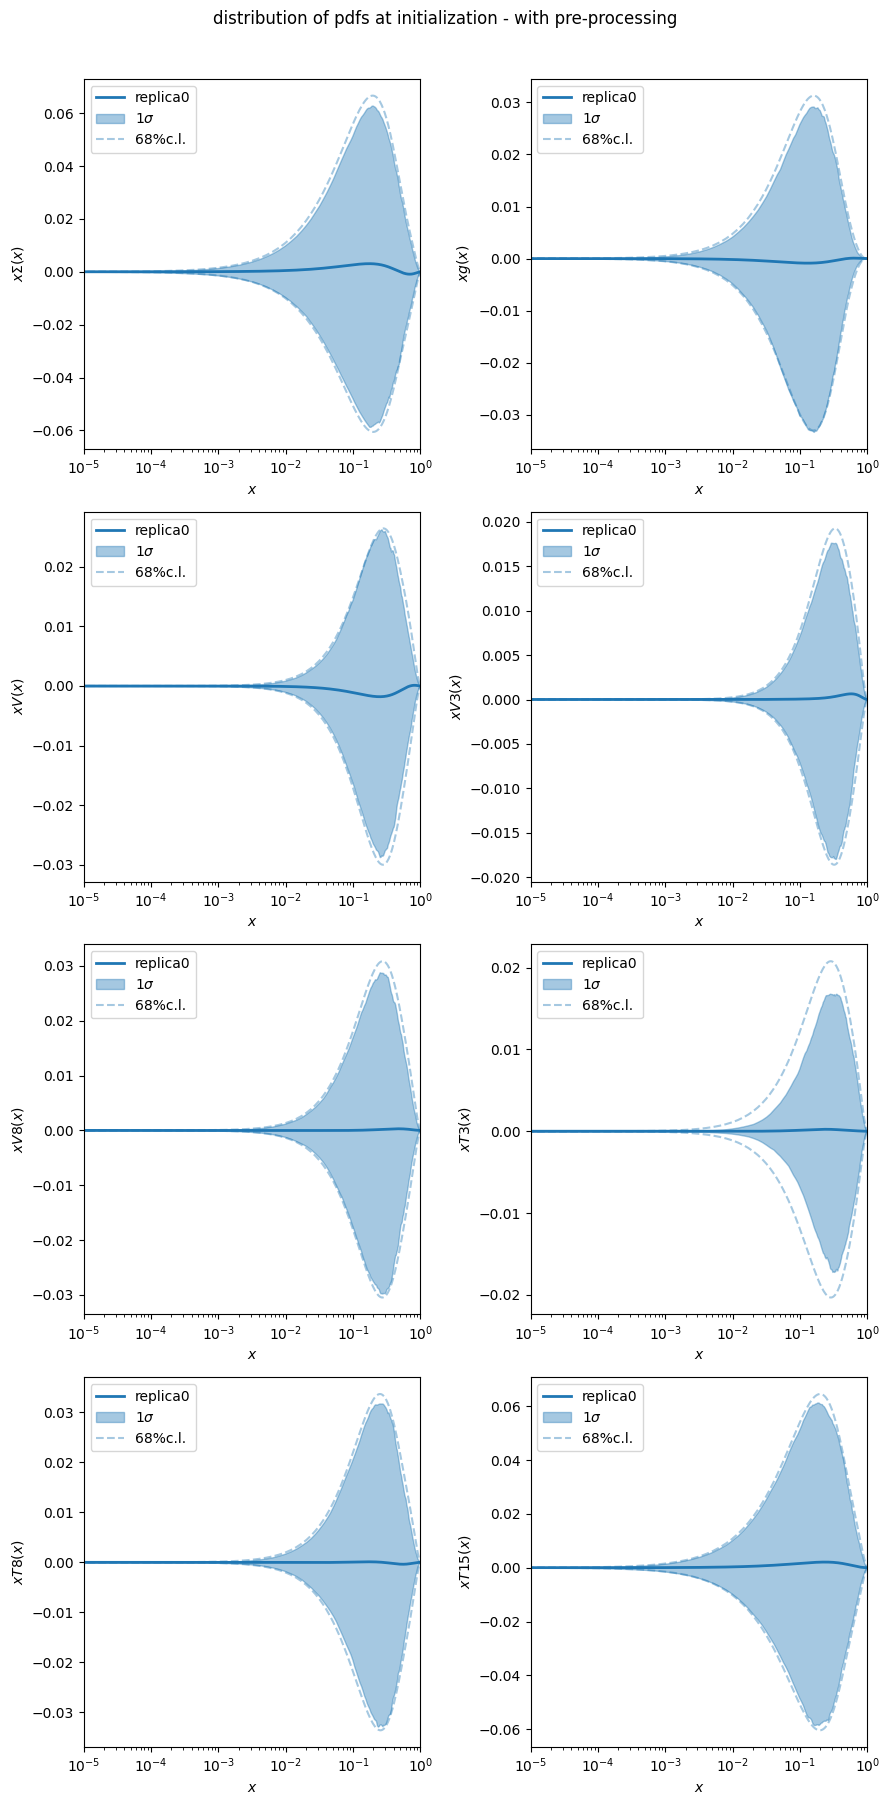

In [11]:
plt.clf()
fig_3, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(input_xgrid[0], input_xgrid[0]*cl_low, input_xgrid[0]*cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig_3.suptitle("distribution of pdfs at initialization - with pre-processing\n", y=1)
fig_3.tight_layout()
fig_3.savefig('nnpdf_prior_no_sumrule.png')

In [12]:
print("smallx: ", *[f"{info['smallx']}" for info in basis_info ])
print("largex: ", *[f"{info['largex']}" for info in basis_info ])

smallx:  [1.094, 1.118] [0.8189, 1.044] [0.457, 0.7326] [0.1462, 0.4061] [0.5401, 0.7665] [-0.4401, 0.9163] [0.5852, 0.8537] [1.082, 1.142]
largex:  [1.46, 3.003] [2.791, 5.697] [1.56, 3.431] [1.745, 3.452] [1.539, 3.393] [1.773, 3.333] [1.533, 3.436] [1.461, 3.1]


# With preprocessing and sum rules

In [13]:
# Generating the NNPDF model
nn_outputs = []
for i in tqdm(range(number_of_networks)):
    # Initialize the NNPDF model with given hyperparameters
    pdf_model = pdfNN_layer_generator(
        nodes=nodes,
        activations=activations,
        initializer_name=initializer_name,
        layer_type="dense",
        flav_info=basis_info,
        fitbasis="EVOL",
        out=14,
        seed=np.random.randint(0, pow(2, 31)),
        dropout=0.0,
        regularizer=None,
        regularizer_args=None,
        impose_sumrule=True, # NOTE: imposing sumrules will break Gaussianity to a large extent
        scaler=None,
        num_replicas = 1,
        photons=None,
        replica_axis=True,
    )

    # Generate predictions in 14-flavor basis
    out = pdf_model.predict( {"pdf_input": input_xgrid}, verbose=False)

    # transform to 8 flavor basis: sigma, g, v, v3, v8, t3, t8, t15
    out = out[0,0,:,[1,2,3,4,5,9,10,11]]
    nn_outputs.append(out)
  
nn_outputs = np.array(nn_outputs)

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


<Figure size 640x480 with 0 Axes>

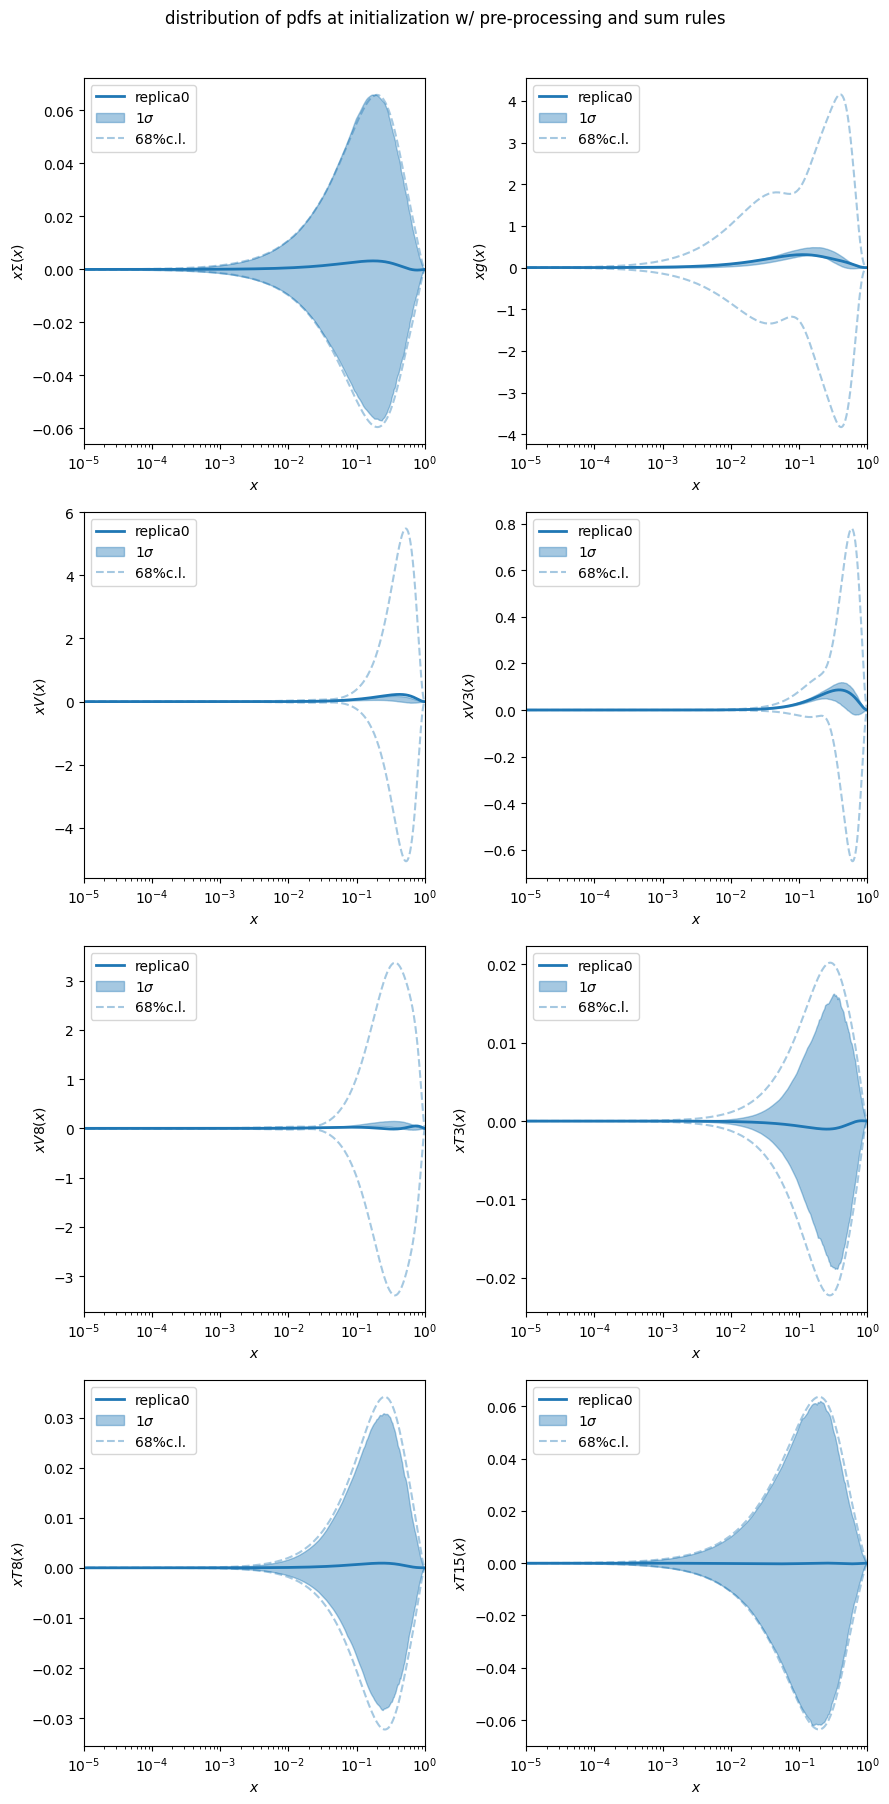

In [14]:
plt.clf()
fig_4, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 18))
for i, (name, ax) in enumerate(zip(pdf_names, axs.flatten())):
    pdf_cv = nn_outputs[:,i,:].mean(axis=0)
    pdf_std = nn_outputs[:,i,:].std(axis=0)
    cl_high = np.nanpercentile(nn_outputs[:,i,:], 84, axis=0)
    cl_low = np.nanpercentile(nn_outputs[:,i,:], 16, axis=0)

    # plot rep0 PDF
    ax.plot(input_xgrid[0], input_xgrid[0]*pdf_cv, color=color, lw=2, label="replica0")

    # 68%c.l. band
    ax.fill_between(input_xgrid[0], input_xgrid[0]*cl_low, input_xgrid[0]*cl_high, alpha=0.4, color=color, label=r"1$\sigma$")

    # 1 std lines
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv - pdf_std), alpha=0.4,ls="dashed", color=color)
    ax.plot(input_xgrid[0], input_xgrid[0]*(pdf_cv + pdf_std), alpha=0.4,ls="dashed", color=color, label="68%c.l.")

    ax.legend()

    ax.set_xscale("log")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"$x{name}(x)$")
    ax.set_xlim(1e-5,1)

fig_4.suptitle("distribution of pdfs at initialization w/ pre-processing and sum rules\n", y=1)
fig_4.tight_layout()
fig_4.savefig('nnpdf_prior')